In [1]:
import os
import time
import sys
from collections import namedtuple
from pathlib import Path
import ipywidgets as widgets

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
import torch
from IPython.display import HTML, FileLink, display
utils_file_path = Path("notebook_utils.py")
notebook_directory_path = Path("model")


sys.path.append(str(utils_file_path.parent))
sys.path.append(str(notebook_directory_path))
from notebook_utils import load_image
from model.u2net import U2NETP
model_config = namedtuple("ModelConfig", ["name", "path","model", "model_args"])
model_path = "model/u2net_lite/u2net_lite.pth"
u2net_lite = model_config(
    name="u2net_lite",
    path= model_path,
    model=U2NETP,
    model_args=(),
)
u2net_model = u2net_lite

In [2]:
# Load the model.
net = u2net_model.model(*u2net_model.model_args)
net.eval()

# Load the weights.
print(f"Loading model weights from: '{model_path}'")
net.load_state_dict(state_dict=torch.load(model_path, map_location="cpu"))

torch.onnx.export(net, torch.zeros((1,3,512,512)), "u2net.onnx")

Loading model weights from: 'model/u2net_lite/u2net_lite.pth'


c:\ProgramData\miniconda3\envs\te\lib\site-packages\torch\nn\functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [3]:
model_ir = ov.convert_model("u2net.onnx")

In [4]:
IMAGE = "0001.jpg"

input_mean = np.array([123.675, 116.28 , 103.53]).reshape(1, 3, 1, 1)
input_scale = np.array([58.395, 57.12 , 57.375]).reshape(1, 3, 1, 1)

image = cv2.cvtColor(
    src=load_image(IMAGE),
    code=cv2.COLOR_BGR2RGB,
)

resized_image = cv2.resize(src=image, dsize=(512, 512))
# Convert the image shape to a shape and a data type expected by the network
# for OpenVINO IR model: (1, 3, 512, 512).
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

input_image = (input_image - input_mean) / input_scale

In [5]:
core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

# Load the network to OpenVINO Runtime.
compiled_model_ir = core.compile_model(model=model_ir, device_name=device.value)
# Get the names of input and output layers.
input_layer_ir = compiled_model_ir.input(0)
output_layer_ir = compiled_model_ir.output(0)

# Do inference on the input image.
result = compiled_model_ir([input_image])[output_layer_ir]


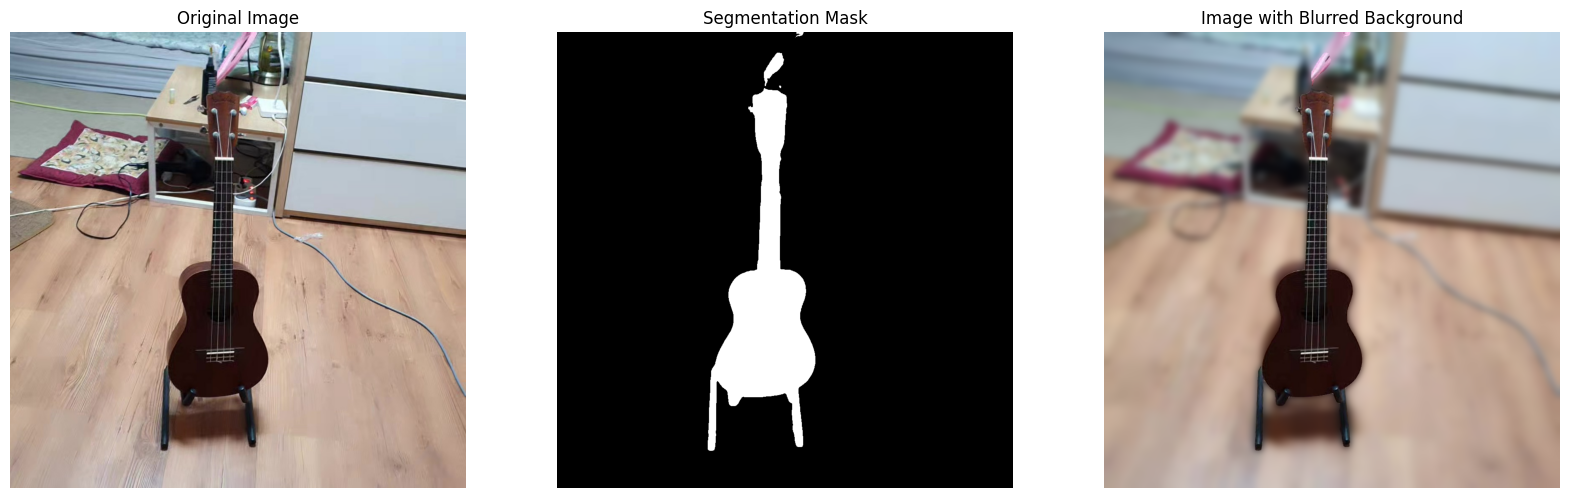

In [17]:
# Perform segmentation (Replace this with your segmentation code)
# You should obtain a mask where the background is 0 and the foreground is 1
mask = np.rint(
    cv2.resize(src=np.squeeze(result), dsize=(image.shape[1], image.shape[0]))
).astype(np.uint8)

# Create a blurred version of the image
blurred_image = cv2.GaussianBlur(image, (51, 51), 0)

# Create a copy of the image
image_c = image.copy()

# Replace the background in bg_removed_result with the blurred background based on the mask
image_c[mask == 0] = blurred_image[mask == 0]

output_directory = "output"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Save the image with the blurred background using the input filename
input_filename = f"{IMAGE}"  # Replace with the actual input filename
output_filename = os.path.join(output_directory, os.path.basename(input_filename))
image_c_rgb = cv2.cvtColor(image_c, cv2.COLOR_BGR2RGB)

# Save the RGB image with the blurred background using the input filename
output_filename = os.path.join(output_directory, os.path.basename(input_filename))
cv2.imwrite(output_filename, image_c_rgb)
"""
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Segmentation Mask")
ax[2].imshow(image_c)
ax[2].set_title("Image with Blurred Background")
for a in ax:
    a.axis("off")

plt.show()
"""